In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Define the labels
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Initialize empty lists to store images and labels
X_train = []
Y_train = []

# Define the image size (224x224)
image_size = 72

# Load the training images
for label in labels:
    folderPath = os.path.join('/kaggle/input/dataset-for-vit/Training', label)
    for img_name in tqdm(os.listdir(folderPath)):
        img_path = os.path.join(folderPath, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(label)

# Load the testing images
for label in labels:
    folderPath = os.path.join('/kaggle/input/dataset-for-vit/Training', label)
    for img_name in tqdm(os.listdir(folderPath)):
        img_path = os.path.join(folderPath, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(label)

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

100%|██████████| 827/827 [00:01<00:00, 435.36it/s]


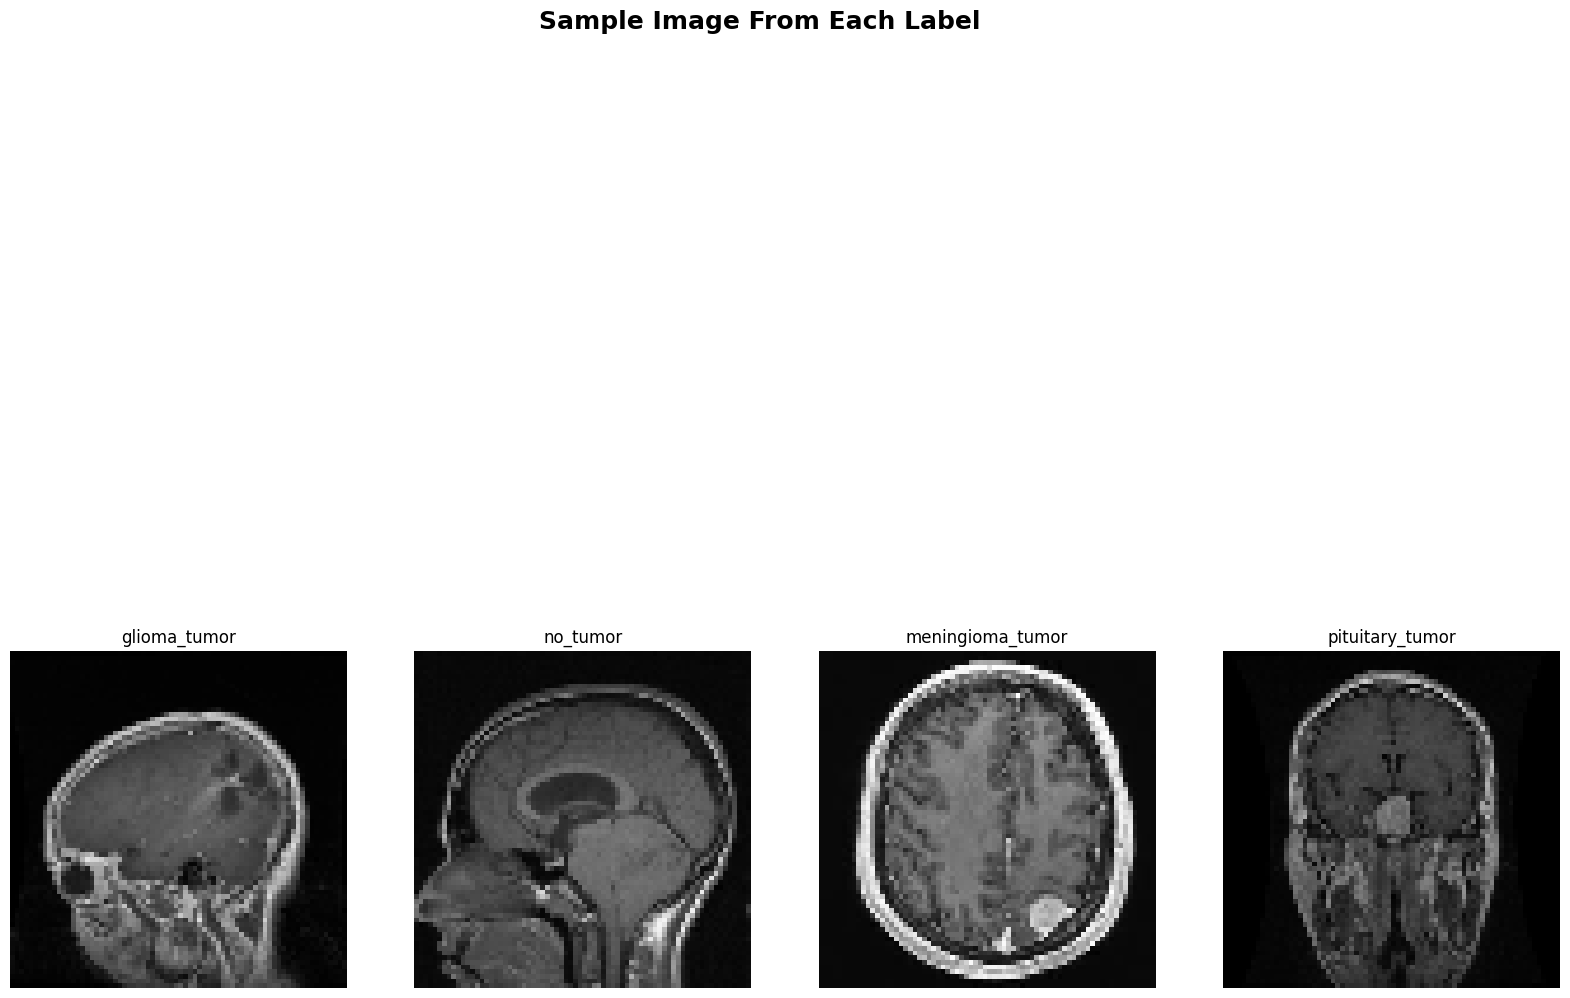

In [6]:
# Display a sample image from each label
k = 0
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
fig.suptitle('Sample Image From Each Label', size=18, fontweight='bold', y=0.9)

for i in labels:
    j = 0
    while True:
        if Y_train[j] == i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(Y_train[j])
            ax[k].axis('off')
            k += 1
            break
        j += 1

In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# Shuffle the dataset
X_train, Y_train = shuffle(X_train, Y_train, random_state=101)

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=101)


In [8]:
# Encode labels as integers
label_encoder = LabelEncoder()
y_train_num = label_encoder.fit_transform(Y_train)
y_test_num = label_encoder.fit_transform(Y_test)

# Convert integer labels to one-hot encoded vectors
Y_train = to_categorical(y_train_num)
Y_test = to_categorical(y_test_num)

In [9]:
n_samples, height, width, channels = X_train.shape

# Reshape X_train for SMOTE
X_train_reshaped = X_train.reshape(n_samples, -1)

# Apply SMOTE to balance the dataset
smote = SMOTE()
X_resampled, Y_resampled = smote.fit_resample(X_train_reshaped, Y_train)

# Reshape X_resampled back to the original dimensions
X_resampled = X_resampled.reshape(-1, height, width, channels)

# Print the shapes of the resampled data
print(X_resampled.shape)
print(Y_resampled.shape)

# Print the class distribution after resampling
train_class_counts = Counter(np.argmax(Y_resampled, axis=1))
print("Resampled class distribution:", train_class_counts)

(5984, 72, 72, 3)
(5984, 4)
Resampled class distribution: Counter({3: 1496, 2: 1496, 1: 1496, 0: 1496})


# implementing the ViT model from Scratch

In [10]:
import tensorflow as tf
from tensorflow.keras import layers

# Reimplement the MLP block
def mlp(x, hidden_units, dropout_rate, output_dim=None):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    if output_dim is not None:
        x = layers.Dense(output_dim, activation=tf.nn.gelu)(x)  # Ensure output matches projection_dim
    return x

In [11]:
# Implement Patch creation as a custom layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [12]:
# Implement Patch Encoder
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [13]:
# Define the Vision Transformer model following the reference notebook
def create_vit_model_reference(input_shape, num_classes, patch_size, projection_dim, num_patches, transformer_layers, num_heads, mlp_units):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Create multiple transformer layers
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-head attention layer
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=mlp_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Final layer normalization
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Flatten and apply dense layers
    representation = layers.Flatten()(representation)
    representation = layers.Dense(units=projection_dim, activation=tf.nn.gelu)(representation)
    representation = layers.Dropout(0.5)(representation)
    # Output layer
    logits = layers.Dense(num_classes)(representation)
    outputs = layers.Activation('softmax')(logits)

    # Create the Keras model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Parameters from the reference notebook
input_shape = (72, 72, 3)
patch_size = 6
num_patches = (input_shape[0] // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_layers = 8
mlp_units = [128, 64]
num_classes = 4

# Create the Vision Transformer model as per the reference notebook
vit_model_reference = create_vit_model_reference(
    input_shape, 
    num_classes, 
    patch_size, 
    projection_dim, 
    num_patches, 
    transformer_layers, 
    num_heads, 
    mlp_units
)

# Show model summary
vit_model_reference.summary()

Model: "functional"

In [ ]:
# Compile the model
vit_model_reference.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = vit_model_reference.fit(
    X_train, Y_train,  # Use the preprocessed and augmented data
    validation_split=0.1,  # Use 10% of the data for validation
    epochs=100,  # Number of epochs
    batch_size=256,  # Batch size as per the reference code
    callbacks=[early_stopping, reduce_lr]
)

 1/19 ━━━━━━━━━━━━━━━━━━━━ 16:40 56s/step - accuracy: 0.2734 - loss: 2.2037

I0000 00:00:1732687268.454249     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3366 - loss: 3.3820   

W0000 00:00:1732687305.010052     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.3385 - loss: 3.3278 - val_accuracy: 0.5106 - val_loss: 1.0310 - learning_rate: 0.0010
Epoch 2/100


W0000 00:00:1732687310.501311     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.4707 - loss: 1.1270 - val_accuracy: 0.6634 - val_loss: 0.8270 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5467 - loss: 1.0136 - val_accuracy: 0.7099 - val_loss: 0.7516 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.6029 - loss: 0.9065 - val_accuracy: 0.7427 - val_loss: 0.6722 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.6241 - loss: 0.8699 - val_accuracy: 0.7640 - val_loss: 0.6152 - learning_rate: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.6400 - loss: 0.8166 - val_accuracy: 0.7814 - val_loss: 0.6050 - learning_rate: 0.0010
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.6660 - loss: 0.7791 - val_accuracy: 0.8472 - val_loss: 0.4832 - learning_rate: 0.0010
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.7022 - loss: 0.7323 - val_a

In [17]:
# Evaluate the model on the test set
test_loss, test_accuracy = vit_model_reference.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9755 - loss: 0.1403
Test Accuracy: 0.9721


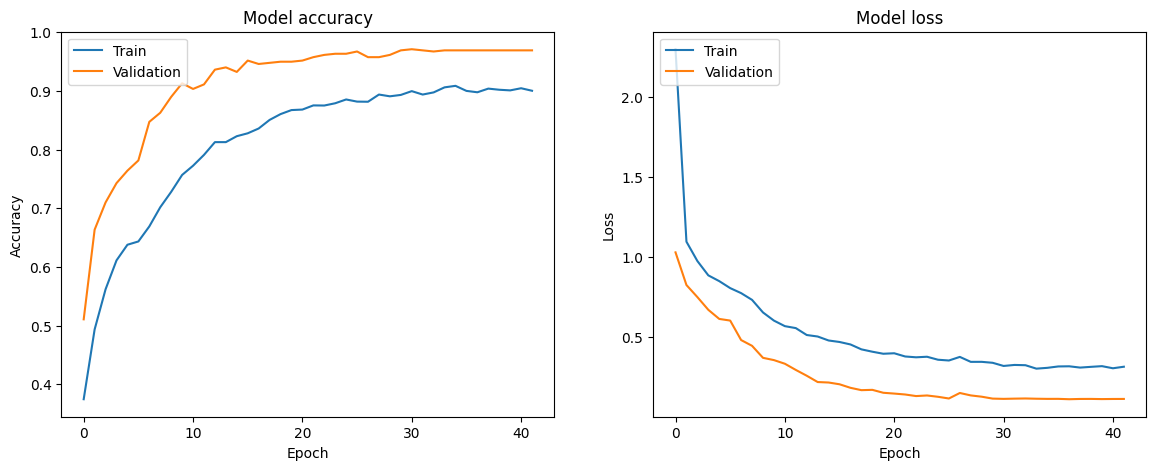

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.96      0.98      0.97       156
        no_tumor       0.96      0.94      0.95       171
meningioma_tumor       0.98      0.99      0.98        88
 pituitary_tumor       0.99      0.99      0.99       159

        accuracy                           0.97       574
       macro avg       0.97      0.97      0.97       574
    weighted avg       0.97      0.97      0.97       574



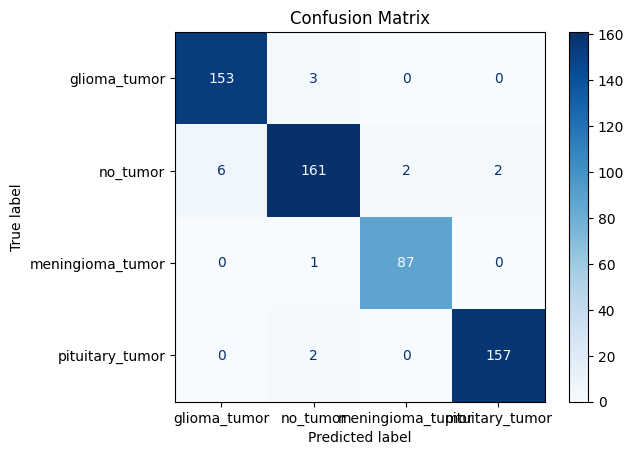

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predictions
y_pred = vit_model_reference.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# implementing EfficientNetB0

In [20]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model

# Load a pre-trained Vision Transformer (EfficientNet as an example here)
base_model = EfficientNetB0(
    input_shape=(72, 72, 3),
    include_top=False,  
    weights='imagenet'  
)

# Freeze the base model's layers
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# Add new classification layers on top of the pre-trained base model
inputs = layers.Input(shape=(72, 72, 3))
x = base_model(inputs, training=False)  
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x) 
# Create the new model
pretrained_vit_model = Model(inputs, outputs)

In [22]:
# Compile the model
pretrained_vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
# Train the pre-trained model
history_pretrained = pretrained_vit_model.fit(
    X_train, Y_train,  
    validation_split=0.1,  
    epochs=50, 
    batch_size=32,  
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 59s 208ms/step - accuracy: 0.6332 - loss: 0.9106 - val_accuracy: 0.8066 - val_loss: 0.4792 - learning_rate: 0.0010
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7647 - loss: 0.5885 - val_accuracy: 0.8511 - val_loss: 0.3886 - learning_rate: 0.0010
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8159 - loss: 0.4752 - val_accuracy: 0.8607 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8400 - loss: 0.4280 - val_accuracy: 0.8685 - val_loss: 0.3329 - learning_rate: 0.0010
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8443 - loss: 0.3962 - val_accuracy: 0.8665 - val_loss: 0.3407 - learning_rate: 0.0010


In [24]:
# Evaluate the model on the test set
test_loss_pretrained, test_accuracy_pretrained = pretrained_vit_model.evaluate(X_test, Y_test)
print(f"Pre-trained Model Test Accuracy: {test_accuracy_pretrained:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.8071 - loss: 0.4894
Pre-trained Model Test Accuracy: 0.7997


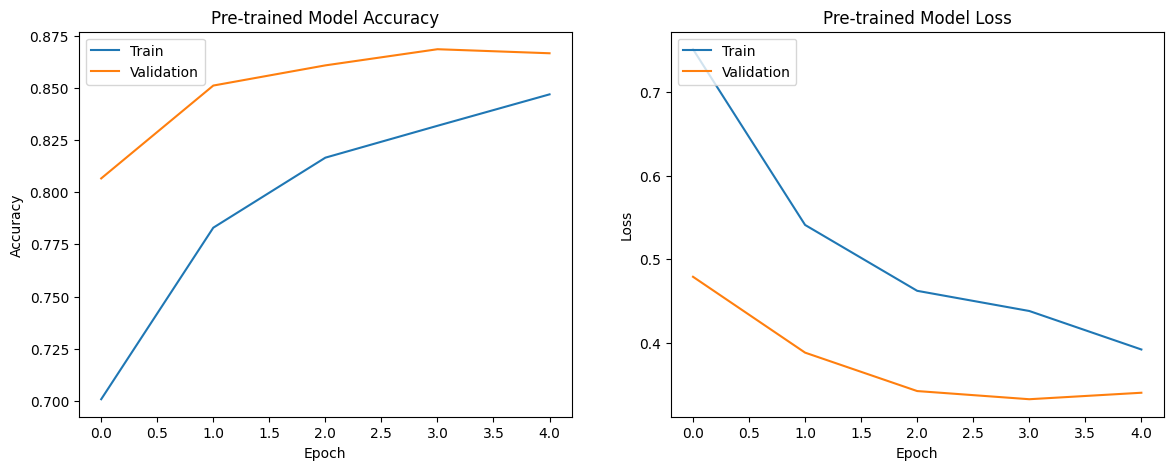

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_pretrained.history['accuracy'])
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('Pre-trained Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_pretrained.history['loss'])
plt.plot(history_pretrained.history['val_loss'])
plt.title('Pre-trained Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get the predictions
y_pred_pretrained = pretrained_vit_model.predict(X_test)
y_pred_classes_pretrained = np.argmax(y_pred_pretrained, axis=1)
y_true_pretrained = np.argmax(Y_test, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step


In [27]:
# Classification report
print("Classification Report:\n", classification_report(y_true_pretrained, y_pred_classes_pretrained, target_names=labels))

# Confusion matrix
cm_pretrained = confusion_matrix(y_true_pretrained, y_pred_classes_pretrained)

# Calculate precision, recall, f1-score, and accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision_pretrained = precision_score(y_true_pretrained, y_pred_classes_pretrained, average='weighted')
recall_pretrained = recall_score(y_true_pretrained, y_pred_classes_pretrained, average='weighted')
f1_pretrained = f1_score(y_true_pretrained, y_pred_classes_pretrained, average='weighted')
accuracy_pretrained = accuracy_score(y_true_pretrained, y_pred_classes_pretrained)

print(f"Precision: {precision_pretrained:.4f}")
print(f"Recall: {recall_pretrained:.4f}")
print(f"F1-Score: {f1_pretrained:.4f}")
print(f"Accuracy: {accuracy_pretrained:.4f}")

Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.78      0.76      0.77       156
        no_tumor       0.70      0.73      0.72       171
meningioma_tumor       0.91      0.77      0.83        88
 pituitary_tumor       0.88      0.93      0.90       159

        accuracy                           0.80       574
       macro avg       0.82      0.80      0.80       574
    weighted avg       0.80      0.80      0.80       574

Precision: 0.8018
Recall: 0.7997
F1-Score: 0.7995
Accuracy: 0.7997


<Figure size 800x800 with 0 Axes>

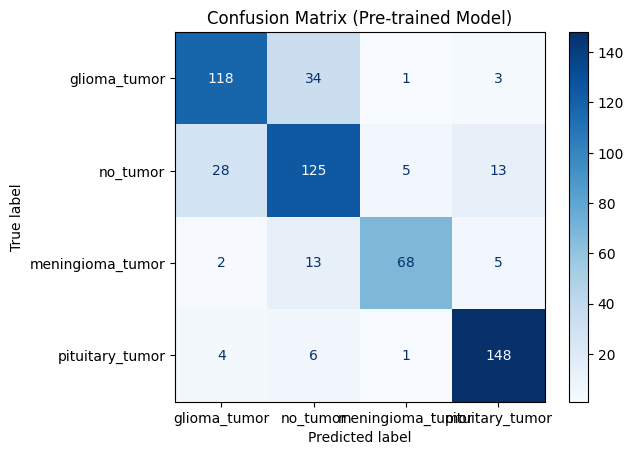

In [28]:
# Plot confusion matrix
plt.figure(figsize=(8, 8))
disp_pretrained = ConfusionMatrixDisplay(confusion_matrix=cm_pretrained, display_labels=labels)
disp_pretrained.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Pre-trained Model)')
plt.show()